In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score


In [3]:
df_indiv = pd.read_csv("../data/features_individual.csv")
df_pairs = pd.read_csv("../data/features_pairs.csv")

df_indiv.head(), df_pairs.head()


(   kw_join  kw_exists  kw_in  kw_group by  kw_order by  kw_limit  kw_where  \
 0        0          0      0            0            1         1         1   
 1        0          0      0            0            1         1         1   
 2        0          0      0            0            0         0         1   
 3        0          0      0            0            0         0         1   
 4        0          0      1            0            0         0         2   
 
    kw_select  kw_count(  kw_sum(  ...  num_or  len_chars  plan_uses_index  \
 0          1          0        0  ...       0        112                1   
 1          1          0        0  ...       0        110                0   
 2          1          1        0  ...       0         59                0   
 3          1          1        0  ...       0         59                0   
 4          1          0        0  ...       0        132                0   
 
    plan_temp_btree  plan_scan  plan_search  pair_id  

In [4]:
df_indiv.describe()


,kw_join,kw_exists,kw_in,kw_group by,kw_order by,kw_limit,kw_where,kw_select,kw_count(,kw_sum(,...,num_equals,num_and,num_or,len_chars,plan_uses_index,plan_temp_btree,plan_scan,plan_search,pair_id,latency_ms
count,800.000000,800.000000,800.000000,800.0,800.00000,800.00000,800.000000,800.0,800.000000,800.0,...,800.000000,800.00000,800.0,800.000000,800.000000,800.0,800.000000,800.000000,800.000000,800.000000
mean,0.135000,0.117500,0.117500,0.0,0.24000,0.24000,1.505000,1.0,0.255000,0.0,...,2.027500,0.62250,0.0,122.577500,0.372500,0.0,0.492500,1.147500,199.500000,4.891091
std,0.341937,0.322217,0.322217,0.0,0.42735,0.42735,0.721544,0.0,0.436134,0.0,...,1.135057,0.68599,0.0,49.187124,0.483773,0.0,0.500257,0.778782,115.541929,5.655999
min,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,1.000000,1.0,0.000000,0.0,...,1.000000,0.00000,0.0,59.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.025000
25%,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,1.000000,1.0,0.000000,0.0,...,1.000000,0.00000,0.0,59.000000,0.000000,0.0,0.000000,1.000000,99.750000,0.032000
50%,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,1.000000,1.0,0.000000,0.0,...,2.000000,1.00000,0.0,132.000000,0.000000,0.0,0.000000,1.000000,199.500000,2.695000
75%,0.000000,0.000000,0.000000,0.0,0.00000,0.00000,2.000000,1.0,1.000000,0.0,...,3.000000,1.00000,0.0,144.000000,1.000000,0.0,1.000000,2.000000,299.250000,9.614750
max,1.000000,1.000000,1.000000,0.0,1.00000,1.00000,3.000000,1.0,1.000000,0.0,...,4.000000,2.00000,0.0,223.000000,1.000000,0.0,1.000000,2.000000,399.000000,16.652000


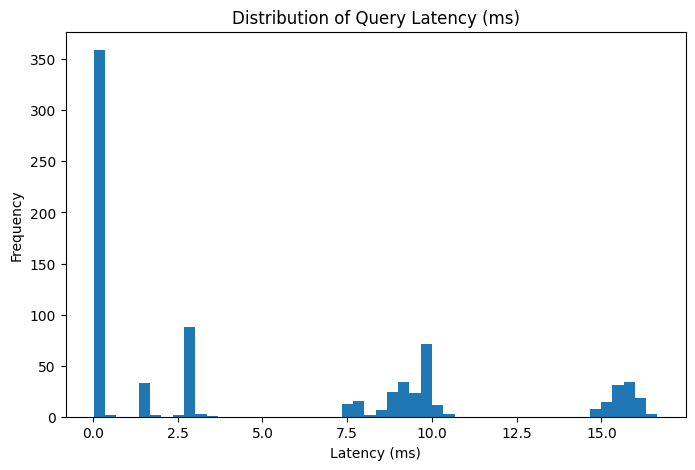

In [5]:
plt.figure(figsize=(8,5))
plt.hist(df_indiv["latency_ms"], bins=50)
plt.title("Distribution of Query Latency (ms)")
plt.xlabel("Latency (ms)")
plt.ylabel("Frequency")
plt.show()

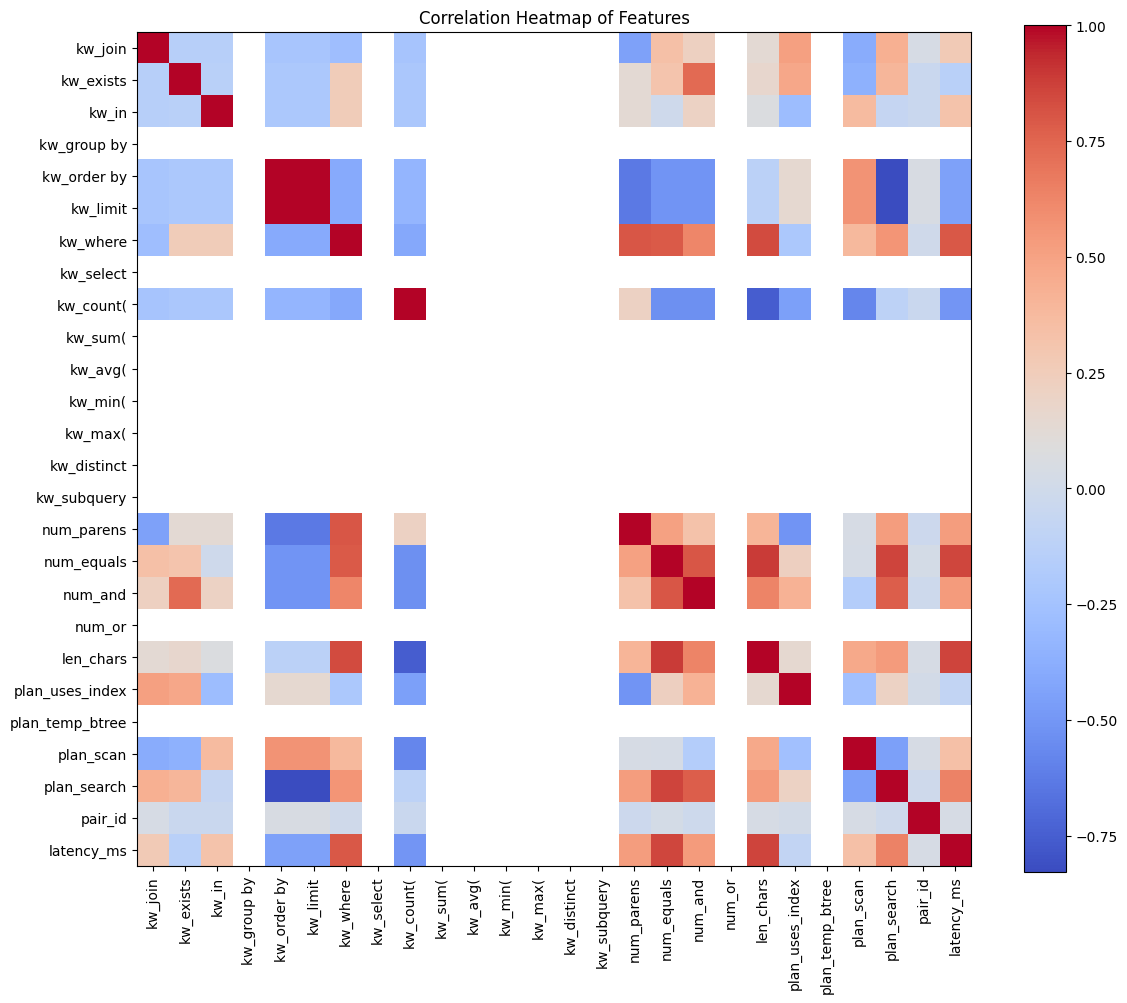

In [6]:

# Compute correlation
corr = df_indiv.corr(numeric_only=True)

plt.figure(figsize=(12,10))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# X & Y ticks
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

In [7]:
y = np.log1p(df_indiv["latency_ms"])
X = df_indiv.drop(columns=["latency_ms", "pair_id", "variant", "tag"])
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

reg = RandomForestRegressor(n_estimators=300, random_state=42)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)

mae = mean_absolute_error(np.expm1(y_test), np.expm1(preds))
r2 = r2_score(y_test, preds)

mae, r2

(0.11045001878738706, 0.995362784829742)

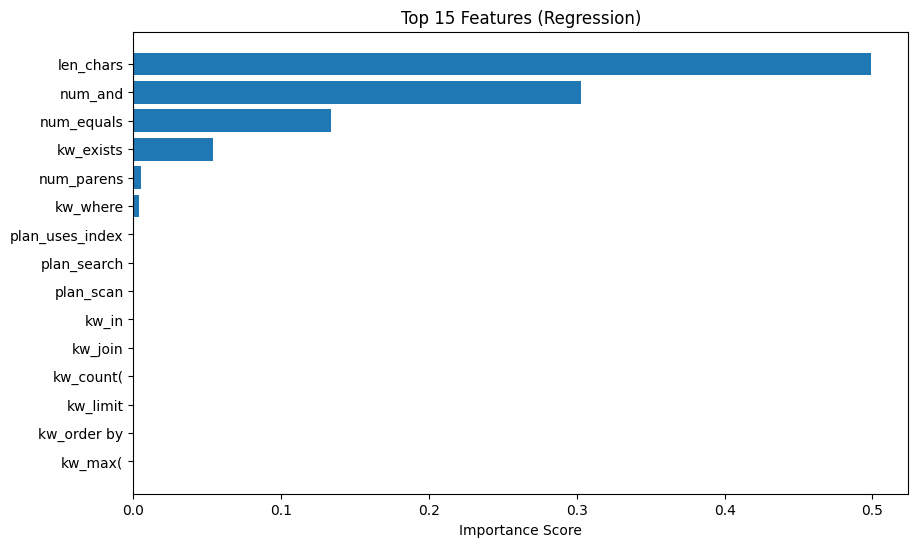

In [8]:
importances = reg.feature_importances_
idx = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10,6))
plt.barh(np.array(X.columns)[idx], importances[idx])
plt.gca().invert_yaxis()
plt.title("Top 15 Features (Regression)")
plt.xlabel("Importance Score")
plt.show()

In [9]:
y_cls = df_pairs["label_A_is_faster"]
X_cls = df_pairs.drop(columns=["pair_id","label_A_is_faster"]).fillna(0)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.25, random_state=42
)

clf = RandomForestClassifier(n_estimators=400, random_state=42)
clf.fit(Xc_train, yc_train)

preds_cls = clf.predict(Xc_test)

acc = accuracy_score(yc_test, preds_cls)
f1 = f1_score(yc_test, preds_cls)

acc, f1

(0.91, 0.9108910891089109)

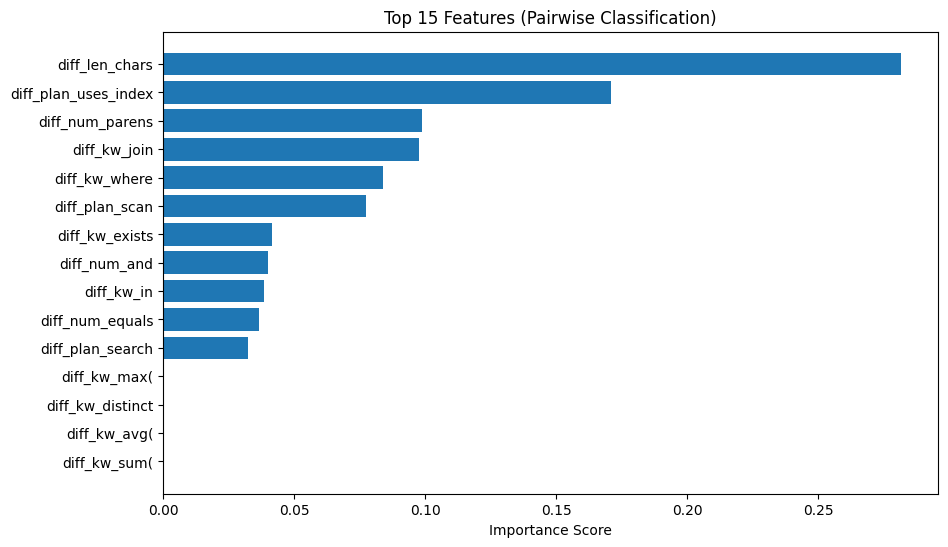

In [10]:
imp = clf.feature_importances_
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(10,6))
plt.barh(np.array(X_cls.columns)[idx], imp[idx])
plt.gca().invert_yaxis()
plt.title("Top 15 Features (Pairwise Classification)")
plt.xlabel("Importance Score")
plt.show()

In [11]:
print("Regression MAE:", mae)
print("Regression R²:", r2)
print("Classification Accuracy:", acc)
print("Classification F1:", f1)

Regression MAE: 0.11045001878738706
Regression R²: 0.995362784829742
Classification Accuracy: 0.91
Classification F1: 0.9108910891089109
